# Deepfake Detection & Awareness Platform

## Dataset Preperation

### Setups and Imports

In [1]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import cv2
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Dropout, Input, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-07-02 14:15:02.342125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751447702.354068 2867070 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751447702.357524 2867070 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751447702.368343 2867070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751447702.368356 2867070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751447702.368357 2867070 computation_placer.cc:177] computation placer alr

In [2]:
# Set memory growth on the GPU before any operations
physical_devices = tf.config.list_physical_devices('GPU')

# Check if GPUs are available
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


### Define Dataset Paths

- These are the folders where your real and fake videos are stored.

- Each list allows us to iterate over them automatically.

In [3]:
real_paths = [
    "./dataset/original_sequences/actors/raw/videos",
    "./dataset/original_sequences/youtube/raw/videos"
]

fake_paths = [
    "./dataset/manipulated_sequences/DeepFakeDetection/raw/videos",
    "./dataset/manipulated_sequences/Deepfakes/raw/videos",
    "./dataset/manipulated_sequences/Face2Face/raw/videos",
    "./dataset/manipulated_sequences/FaceSwap/raw/videos",
    "./dataset/manipulated_sequences/NeuralTextures/raw/videos",
    "./dataset/manipulated_sequences/FaceShifter/raw/videos"
]


### Train Test Split

In [4]:
# Get all video paths first
real_videos = []
for path in real_paths:
    real_videos += [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.mp4')]

fake_videos = []
for path in fake_paths:
    fake_videos += [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.mp4')]

# Labels
real_labels = [0] * len(real_videos)
fake_labels = [1] * len(fake_videos)

# Combine and split
all_videos = real_videos + fake_videos
all_labels = real_labels + fake_labels

train_videos, test_videos, train_labels, test_labels = train_test_split(all_videos, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
train_videos, val_videos, train_labels, val_labels = train_test_split(train_videos, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

### Frame Extraction Function

- Opens a video file.

- Captures 1 frame every n frames (e.g., every 5th frame).

- Stops after collecting max_frames (40 in this case).

- Resizes each frame for model input.

- Applying some Data Augmentation as well

In [4]:
def extract_frames(video_path, max_frames=40, every_n=3, resize=(160, 160), augment=True):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % every_n == 0:
            frame = cv2.resize(frame, resize)

            if augment:
                # Random horizontal flip
                if random.random() < 0.5:
                    frame = cv2.flip(frame, 1)

                # Random brightness adjustment
                if random.random() < 0.5:
                    frame = cv2.convertScaleAbs(frame, alpha=1.0, beta=random.randint(-10, 10))

            frames.append(frame)

        frame_count += 1

    cap.release()

    # Pad with the last frame if needed
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1])

    return np.array(frames)


### Load Dataset from all Videos

- Goes through each video in the given list of directories.

- Extracts frames using the previous function.

- Stores the video’s frames and assigns the correct label:

    - 0 for real

    - 1 for fake

In [6]:
def video_frame_generator(video_list, label_list, batch_size=4, augment=False):
    data, labels = [], []
    for video_path, label in zip(video_list, label_list):
        frames = extract_frames(video_path, max_frames=40, augment=augment)
        if frames.shape[0] == 40:
            data.append(frames)
            labels.append(label)
        if len(data) == batch_size:
            yield np.array(data), tf.keras.utils.to_categorical(labels, num_classes=2)
            data, labels = [], []

    # Yield remaining data if any
    if data:
        yield np.array(data), tf.keras.utils.to_categorical(labels, num_classes=2)


#### Create Datasets

In [7]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: video_frame_generator(train_videos, train_labels, batch_size=4, augment=True),
    output_signature=(
        tf.TensorSpec(shape=(None, 40, 160, 160, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).repeat().prefetch(buffer_size=2)

val_dataset = tf.data.Dataset.from_generator(
    lambda: video_frame_generator(val_videos, val_labels, batch_size=4),
    output_signature=(
        tf.TensorSpec(shape=(None, 40, 160, 160, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).prefetch(buffer_size=2)

test_dataset = tf.data.Dataset.from_generator(
    lambda: video_frame_generator(test_videos, test_labels, batch_size=4),
    output_signature=(
        tf.TensorSpec(shape=(None, 40, 160, 160, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
)


I0000 00:00:1751447704.517115 2867070 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1751447704.518332 2867070 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6135 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6


## Xception + LSTM for Deepfake Detection

### Define the Model (Xcepion + LSTM)

- TimeDistributed applies the CNN (Xception) to each frame individually.

- GlobalAveragePooling2D reduces the spatial dimensions after Xception.

- LSTM captures temporal patterns across the video frames.

- Dropout helps prevent overfitting.

- Dense(2) for binary classification (real/fake).

In [8]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Unfreeze top 40 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model = Sequential([
    Input(shape=(40, 160, 160, 3)),
    TimeDistributed(base_model),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(128),  # simpler, unidirectional
    Dropout(0.5),
    Dense(2, activation='softmax')
])


### Compile and Train the Model

In [9]:
batch_size = 4

ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=len(train_videos) // batch_size,
    validation_steps=len(val_videos) // batch_size,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30


I0000 00:00:1751447800.569484 2867149 cuda_dnn.cc:529] Loaded cuDNN version 90501


216/216 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.5180 - loss: 0.7095 - val_accuracy: 0.5417 - val_loss: 0.6878
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.5669 - loss: 0.6795 - val_accuracy: 0.5729 - val_loss: 0.6797
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6045 - loss: 0.6673 - val_accuracy: 0.6562 - val_loss: 0.6712
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.6097 - loss: 0.6552 - val_accuracy: 0.6979 - val_loss: 0.6684
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.6279 - loss: 0.6491 - val_accuracy: 0.7083 - val_loss: 0.6651
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6504 - loss: 0.6425 - val_accuracy: 0.7396 - val_loss: 0.6619
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.6377 - loss: 0.6276 - val_accuracy: 0.7396 - val_loss: 0.6586
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7073 - loss: 0.5976 - val_accuracy: 0.697

### Visualizing validation Curve

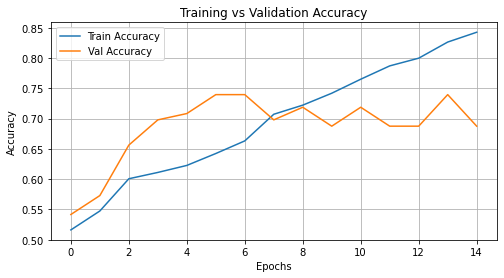

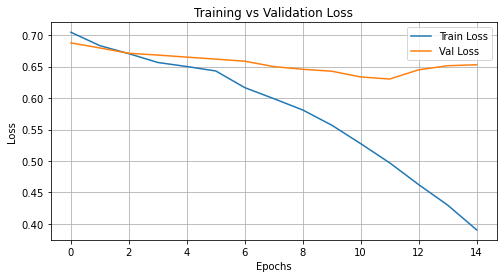

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
print(len(train_videos))

864


In [12]:
print(len(test_videos))

240


In [13]:
print(len(val_videos))

96


In [14]:
model.save("Deepfake_Model2.h5")

In [15]:
# Evaluate
loss, acc = model.evaluate(test_dataset)
print(f"Test accuracy: {acc:.4f}, loss: {loss:.4f}")

# No infinite loop during test
loss, acc = model.evaluate(test_dataset, steps=len(test_videos) // batch_size)
print(f"Test accuracy: {acc:.4f}, loss: {loss:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6423 - loss: 0.6705
Test accuracy: 0.6625, loss: 0.6451


2025-07-02 16:08:57.259541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-02 16:08:57.260041: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/ayesha-yousaf/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6423 - loss: 0.6705
Test accuracy: 0.6625, loss: 0.6451


### Predicting on Test Set Manually (Extra)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []

for batch_x, batch_y in test_dataset:
    preds = model.predict(batch_x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_y.numpy(), axis=1))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [10]:
from tensorflow.keras.models import load_model
model = load_model("best_model.keras")

I0000 00:00:1751534777.065703 3119890 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6135 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6


### LIME on Video Input

In [6]:
def predict_video_lime(input_frames_batch):
    # LIME sends input as (N, 30, 160, 160, 3)
    return model.predict(input_frames_batch)


In [12]:
import cv2
import numpy as np
import random
import ipywidgets as widgets
import matplotlib.pyplot as plt

progress = widgets.FloatProgress(value=70, min=0, max=100)
progress.style.bar_color = 'green'  # This should work now
display(progress)


FloatProgress(value=70.0, style=ProgressStyle(bar_color='green'))

#### Use LIME Image Explainer (for a single frame in a video)

Apply LIME to one frame (say frame 10) and explain its role:

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

Text(0.5, 1.0, 'LIME Explanation for Frame 10')

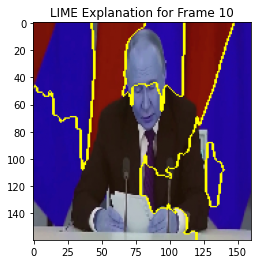

In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Pick a frame from one video
sample_video = extract_frames("sample_deepfake_video.mp4", max_frames=30)
sample_frame = sample_video[10]

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    sample_frame,
    classifier_fn=lambda img_batch: predict_video_lime(np.expand_dims(img_batch, axis=1)),  # dummy wrapper
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation for Frame 10")

In [1]:
import ipywidgets as widgets
print(widgets.__version__)


8.1.7
